In [100]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as scipy
sys.path.append("..\\backtesting")
import dynamic_backtesting as db
plt.style.use('seaborn')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["grey", "green", "black", "deepskyblue", "orange", "lime", "purple", "Gold", "brown", "blue", "pink"]) 

In [2]:
assets = {"EEM": "Emerging Markets",
           "IVV": "S&P 500",
           "IEV": "MSCI Europe",
           "IXN": "Global Tech",
           "IYR": "US Real Estate",
           "IXG": "Global Financials",
           "EXI": "Global Industrials",
           "GC=F": "Gold Futures", 
           "BZ=F": "Brent Crude Oil Futures",
           "HYG": "High-Yield Corporate Bonds",
           "TLT": "20+ Year Treasury Bonds"}
tickers = list(assets.keys())
asset_names = list(assets.values())
#spx = pd.read_csv('../data/spx.csv').stack().tolist()

**Henter return data udfra tickers**

In [173]:
return_data =db.download_return_data(tickers, save_to_csv=False)
#cov = return_data.cov()

[*********************100%***********************]  11 of 11 completed
                BZ=F       EEM       EXI      GC=F       HYG       IEV  \
Date                                                                     
2008-01-02  4.251463 -1.650019 -0.473783  2.647021 -1.211286 -0.271136   
2008-01-03 -0.245296  0.899744 -0.142801  1.096852 -0.190921  0.175392   
2008-01-04 -0.829916 -3.003688 -2.971562 -0.380892 -0.110781 -2.346105   
2008-01-07 -2.479597  0.732688 -0.982662 -0.405515 -0.594832  0.501988   
2008-01-08  1.218351 -0.775377 -0.744280  2.140533 -0.577962 -0.909830   
...              ...       ...       ...       ...       ...       ...   
2021-09-27  1.844029  0.649866 -0.131962  0.017149 -0.091001 -0.148785   
2021-09-28 -0.553253 -1.291332 -1.767280 -0.811426 -0.455429 -2.197803   
2021-09-29 -0.568968 -0.931618 -0.067250 -0.823830  0.183001 -0.228526   
2021-09-30 -0.152598  0.800323 -1.152522  1.963407 -0.114169 -0.515366   
2021-10-01  0.967909 -0.099244  0.740428 

**Henter parametre**

In [174]:
coef, residuals, sigmas = db.fit_garch_model(3463)
mu, o, al, be, ka, shape, dcca, dccb, joint_shape = db.parse_garch_coef(coef, 11, "sGARCH11")

**Laver data til IRF plot**

In [183]:
t=1000
mu_T=mu.transpose()
irf_data=pd.DataFrame(mu_T.repeat(t,axis=0),columns=asset_names)
#Indsætter chok
irf_data.iloc[int(t/2),6]=8

**Calculate $\Omega_t$**

In [184]:
irf_omega_s=db.calc_Omega_ts(irf_data,sigmas,residuals, dcca, dccb,mu, o, al, be, ka)

**Calculate weight, $v_t$**

In [185]:
irf_weights=db.calc_weights_garch_no_trading_cost(irf_omega_s)

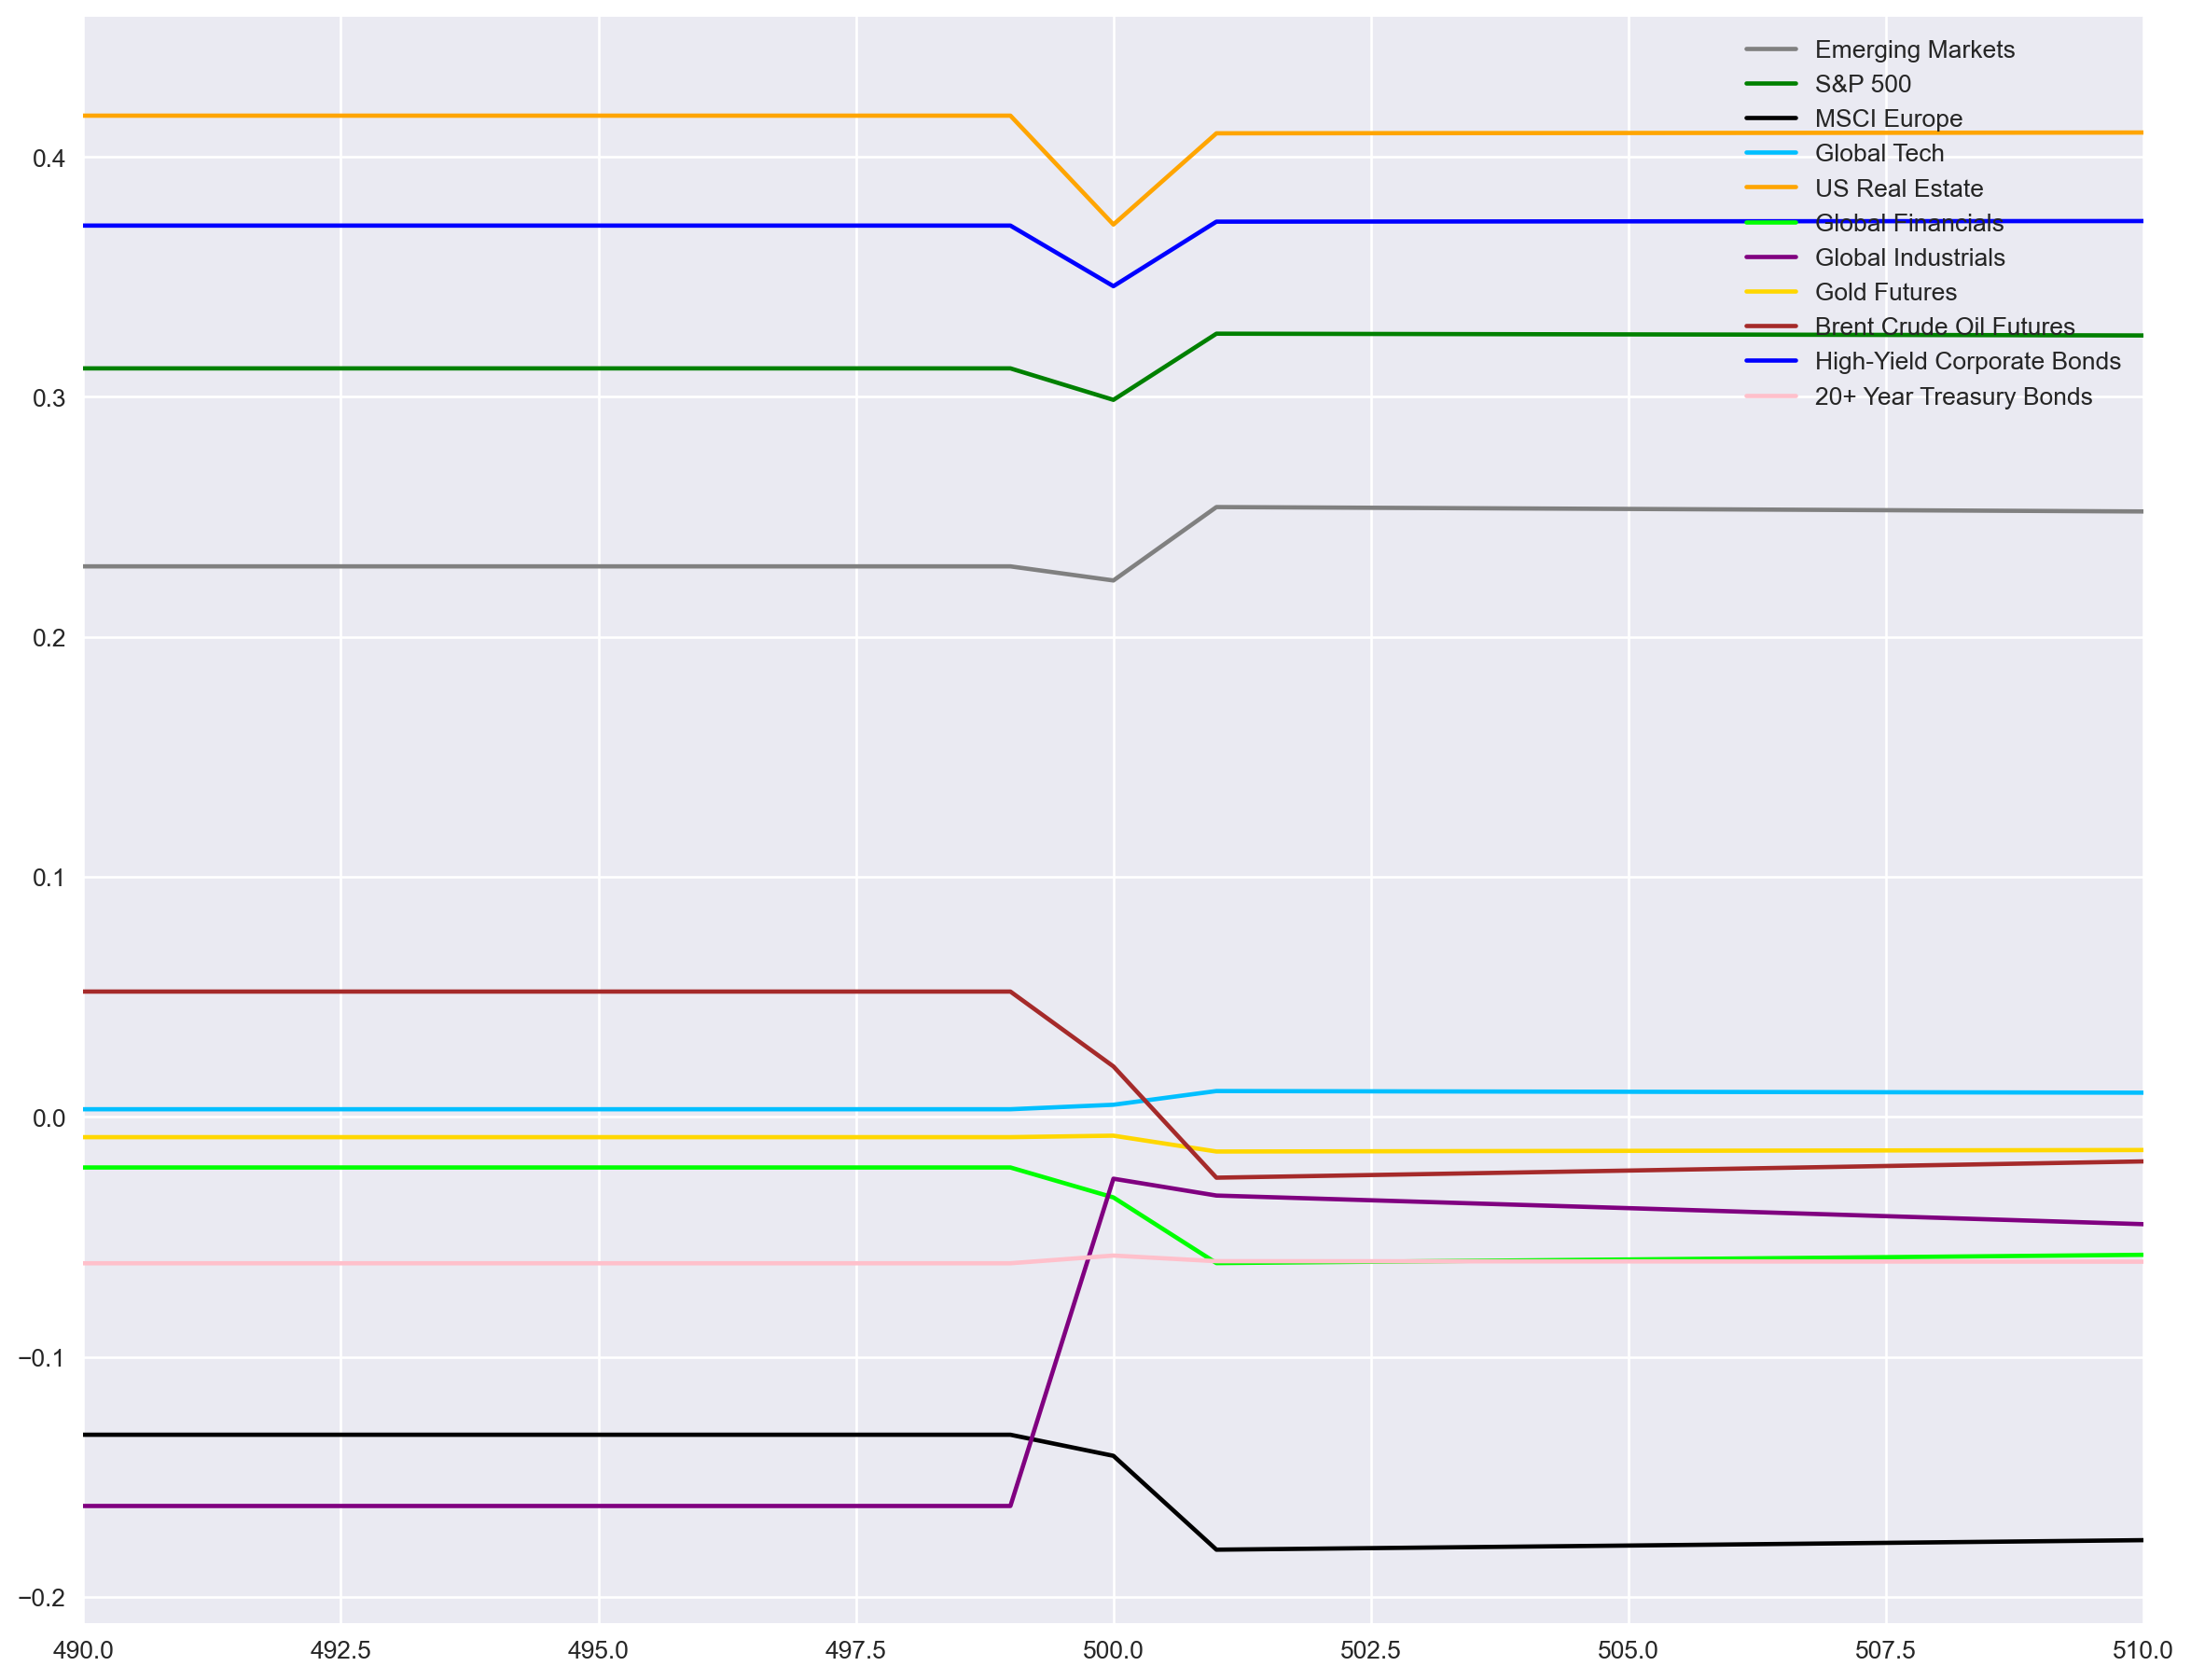

In [186]:
spread=10
#plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(15,12), dpi=190)
ax.plot(irf_weights)
ax.set_xlim(int(t/2-spread),int(t/2+spread))
ax.legend(asset_names, loc='upper right')
#ax.set_xlabel('Returns') 
#ax.set_ylabel('Probability Density',loc='top', rotation = 0, labelpad = -110) 

[array([[ 4.31083453e-04,  1.19246047e-04,  3.52936644e-04,
         1.44284866e-04,  1.73203549e-04,  2.77605968e-04,
         4.53890903e-04,  2.08082979e-04,  4.64578755e-04,
         7.48285701e-05, -2.35462141e-04],
       [ 1.19246047e-04,  5.56941632e-04,  1.02353038e-03,
         7.19149701e-05,  5.68083142e-04,  9.11765112e-04,
         1.42216896e-03,  6.41217215e-04,  1.30890620e-03,
         3.53161316e-04, -4.57027879e-04],
       [ 3.52936644e-04,  1.02353038e-03,  2.97076230e-03,
         2.56591341e-04,  1.48708977e-03,  2.28256177e-03,
         3.82009442e-03,  1.78265673e-03,  3.58924603e-03,
         8.85933777e-04, -1.62383059e-03],
       [ 1.44284866e-04,  7.19149701e-05,  2.56591341e-04,
         2.22478020e-03,  1.37310555e-04,  1.98895195e-04,
         1.88732411e-04,  2.36747140e-05,  2.80118898e-04,
         2.15329370e-05,  3.28308719e-04],
       [ 1.73203549e-04,  5.68083142e-04,  1.48708977e-03,
         1.37310555e-04,  2.22417072e-03,  1.22082625e-03,
 

In [166]:
print(al)

[[0.07526287]
 [0.10703612]
 [0.08020409]
 [0.04754533]
 [0.09773305]
 [0.08825007]
 [0.09076743]
 [0.09276642]
 [0.07731074]
 [0.11109754]
 [0.05960649]]
